# Automatic lightfield completion

Train a VAE on the images of a cross-shaped lightfield array to predict the diagonals

In [1]:
# Imports and data loading

import os
from dataloaders import hci4d
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import lightfield_vae as vae
from utils import show_scene, show_view_sequence
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.nn import functional as F

DATA_ROOT = os.path.join('data', 'SyntheticLightfieldData')
BATCH_SIZE = 2
use_cuda = torch.cuda.is_available()
print("Use cuda:", use_cuda)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_set = hci4d.HCI4D(os.path.join(DATA_ROOT, 'training'))
test_set = hci4d.HCI4D(os.path.join(DATA_ROOT, 'test'))
print("Training set length:", len(train_set))
print("Test set length:", len(test_set))

%load_ext autoreload
%autoreload 2

Use cuda: True
Training set length: 27
Test set length: 1


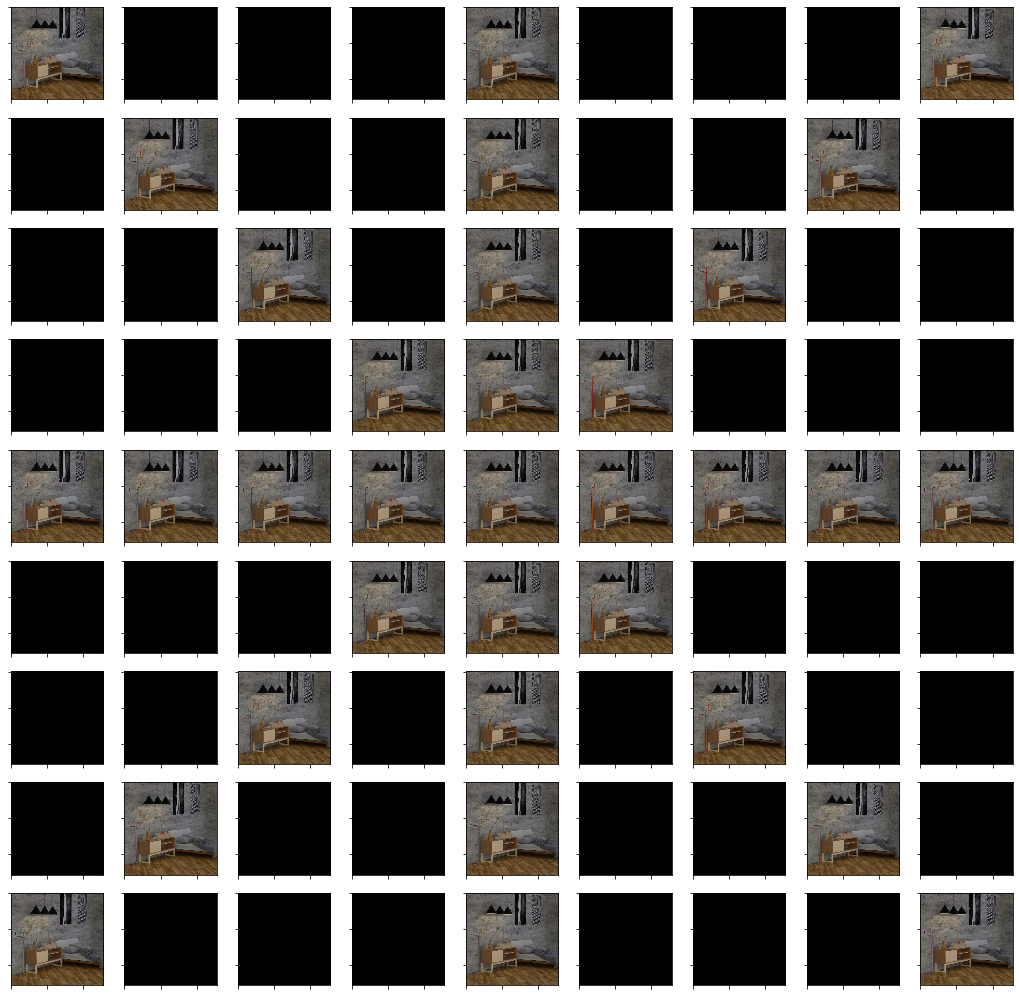

In [2]:
# Show an example image from the test set
show_scene(test_set.load_scene(0))

In [5]:
# Training and testing routines similar to the PyTorch implementation
# but modified for lightfield arrays

device = torch.device("cuda" if use_cuda else "cpu")
model = vae.VAE([400], 20, (512, 512)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Load horizontal lightfield data
# TODO: How to handle different directions
# Todo: Data Augmentation: RandomCrop, RedistColor, Contrast, Brightness, RandomRotate
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, **kwargs)

n_train = len(train_loader.dataset)
n_test = len(test_loader.dataset)
print("Data samples for training:", n_train)
print("Data samples for testing:", n_test)

def train_step(data):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = vae.loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss = loss.item()
    optimizer.step()
    return train_loss
    
def train(epoch, log_interval=1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        h_views, v_views, i_views, d_views, center, gt, mask, index = data
        loss_h = train_step(h_views)
        loss_v = train_step(v_views)
        train_loss += ((loss_h+loss_v)/2)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * (len(h_views)), n_train,100. * batch_idx / len(train_loader),
                    (loss_h+loss_v)/ (len(h_views)+len(v_views))))
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def train_single_scene(epoch, log_interval=1):
    model.train()
    h_views, v_views, i_views, d_views, center, gt, mask, index = train_loader.__iter__().__next__()
    loss_h = train_step(h_views)
    loss_v = train_step(v_views)
    train_loss = ((loss_h+loss_v)/2)
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, (loss_h+loss_v)/ (len(h_views)+len(v_views))))
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss))

Data samples for training: 27
Data samples for testing: 1


In [6]:
# Train the model for some epochs and run the test
for epoch in range(1, 11):
    train(epoch, log_interval=5)

Train Epoch: 1 [0/27 (0%)]	Loss: 5297157.000000
Train Epoch: 1 [10/27 (36%)]	Loss: 4970197.250000
Train Epoch: 1 [20/27 (71%)]	Loss: 4893181.250000
====> Epoch: 1 Average loss: 4975132.1204
Train Epoch: 2 [0/27 (0%)]	Loss: 5109546.000000
Train Epoch: 2 [10/27 (36%)]	Loss: 4981617.750000
Train Epoch: 2 [20/27 (71%)]	Loss: 5098626.250000
====> Epoch: 2 Average loss: 5013003.7685
Train Epoch: 3 [0/27 (0%)]	Loss: 5020442.750000
Train Epoch: 3 [10/27 (36%)]	Loss: 5007902.500000
Train Epoch: 3 [20/27 (71%)]	Loss: 5279296.500000
====> Epoch: 3 Average loss: 5023283.7870
Train Epoch: 4 [0/27 (0%)]	Loss: 5222667.250000
Train Epoch: 4 [10/27 (36%)]	Loss: 5048815.000000
Train Epoch: 4 [20/27 (71%)]	Loss: 4956360.250000
====> Epoch: 4 Average loss: 5004996.6204
Train Epoch: 5 [0/27 (0%)]	Loss: 4741815.250000
Train Epoch: 5 [10/27 (36%)]	Loss: 4978802.500000
Train Epoch: 5 [20/27 (71%)]	Loss: 4873320.750000
====> Epoch: 5 Average loss: 4952586.5741
Train Epoch: 6 [0/27 (0%)]	Loss: 4954800.750000
Tr

True decreasing diagonal:


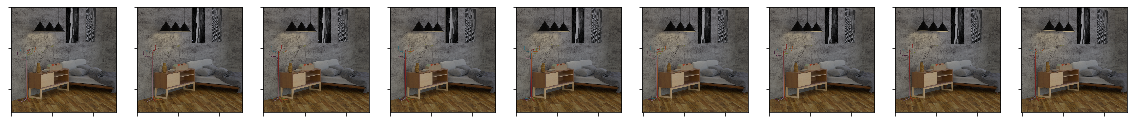

Predicted:


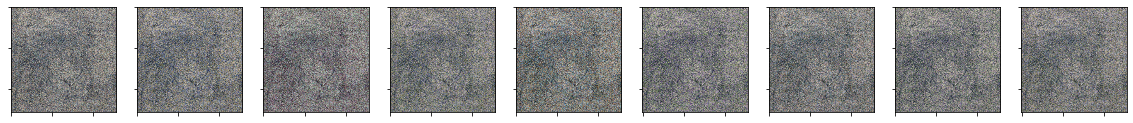

====> Test set loss: 0.1786


In [9]:
# Test
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        h_views, v_views, i_views, d_views, center, gt, mask, index = data
        data_h = h_views[0].to(device)
        data_v = v_views[0].to(device)
        mu_h, var_h = model.encode(data_h.view(-1, 512*512))
        mu_v, var_v = model.encode(data_v.view(-1, 512*512))
        z_h, z_v = model.reparameterize(mu_h, var_h), model.reparameterize(mu_v, var_v)
        predicted = model.decode(z_h + z_v)
        test_loss += F.l1_loss(predicted, d_views[0].to(device).view(-1, 512*512))
        if i == 0:
            print("True decreasing diagonal:")
            show_view_sequence(d_views[0])
            print("Predicted:")
            show_view_sequence(predicted.cpu().view(9, 3, 512, 512), save=True)

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))